In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import pandas as pd
import functools
# import community

from scipy import sparse
from scipy.sparse import linalg
import time
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from math import sqrt

from shapely.ops import cascaded_union
pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# initialise path, names, etc.

city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

buildings = "C:/Users/g_filo01/sciebo/GIS Data/London/Buildings/London_buildingsBase.shp"

path_small = 'C:/Users/g_filo01/sciebo/GIS Data/London/OS_Roads_Working/OS_roads_final.shp'
# path_large = 'C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_Network/boston_sn_26986_clipped_8000_noHW.shp'

In [2]:
# Boston

tmp = gpd.read_file('C:/Users/g_filo01/sciebo/Scripts/Tools/Outputs/bh_2002_26986.shp').to_crs(epsg=26986)
buffer = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/buffer_4000.shp').to_crs(epsg=26986)
buildings = tmp[tmp.geometry.within(buffer.geometry.loc[0])]

In [ ]:
# to simplify 
# when a building is divided in several polygons import in QGIS --> dissolve, single to multipart, join attributes by location
# buildings.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/building_to_dissolve.shp")
# load shapefile again
# buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/bh_26986_simplified.shp').to_crs(epsg=26986)

In [3]:
buildings = buildings[['ROOF', 'GND', 'geometry']]
buildings["area"] = buildings['geometry'].area
buildings.columns = ['height', 'base','geometry', 'area']

buildings.head()

,height,base,geometry,area
6625,8.280,0.700,"POLYGON ((237513.4608405583 904788.1487156174,...",1926.803
6632,8.900,0.820,"POLYGON ((237735.701000562 904786.3753156194, ...",1126.634
6641,15.370,4.710,"POLYGON ((238074.2963205655 904592.5663956183,...",4202.795
6645,11.700,1.440,"POLYGON ((237509.0300405587 904583.7148356194,...",4287.751
6655,26.640,9.310,"POLYGON ((237360.2225505561 904640.8941956179,...",1368.853


In [4]:
buildings['BUILD_ID']=buildings.index.values.astype(int)

In [6]:
# all buildings in 4 km buffer to use as obstacles in ArcScene and for some analyis in this notebook
buildings.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/obstacles.shp")

In [5]:
# small dataset, only area of interest

buffer_city_center = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center_buffer_100.shp'
                                  ).to_crs(epsg=26986).dissolve(by='intersec')
buildings_clip = buildings[buildings.geometry.within(buffer_city_center.geometry.loc[1])].copy()

In [8]:
buildings_clip.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/buildings_sight.shp")

In [ ]:
buildings_clip.head()

## Extension, Facade Area

In [ ]:
#computing Envelope polygon

for index, row in buildings_clip.iterrows():
    t = row['geometry'].envelope
    coords = mapping(t)['coordinates'][0]
    d = [(Point(coords[0])).distance(Point(coords[1])), (Point(coords[1])).distance(Point(coords[2]))]

    width = min(d)
    length = max(d)
    
    buildings_clip.set_value(index, 'width', width)
    buildings_clip.set_value(index, 'length', length)

In [ ]:
buildings_clip['extension']=buildings_clip.area*(buildings_clip.length/buildings_clip.width)
buildings_clip['facade_area']=buildings_clip['height']*(buildings_clip.width)

## Prominence

In [ ]:
buildings_clip['prominence']=0.0
# a dataset containing a larger region of buildings than the one object of analyis is required here

In [10]:
buildings_clip.head()

,height,base,geometry,area,BUILD_ID
12867,23.530,1.720,"POLYGON ((237109.7499205534 901488.5575756297,...",2466.090,12867
12869,11.750,-1.290,"POLYGON ((237027.0227605512 901476.8202856297,...",526.515,12869
12872,7.210,-0.380,"POLYGON ((237044.3070005517 901416.8178456295,...",292.290,12872
12873,20.490,1.390,"POLYGON ((237142.3675505524 901348.946465629, ...",2620.960,12873
12874,12.170,1.150,"POLYGON ((237199.5938805515 901363.4296656293,...",793.817,12874


In [14]:
buildings_clip.head()

,height,base,geometry,area,BUILD_ID,prominence
12867,23.530,1.720,"POLYGON ((237109.7499205534 901488.5575756297,...",2466.090,12867,68296.187
12869,11.750,-1.290,"POLYGON ((237027.0227605512 901476.8202856297,...",526.515,12869,44066.485
12872,7.210,-0.380,"POLYGON ((237044.3070005517 901416.8178456295,...",292.290,12872,51894.981
12873,20.490,1.390,"POLYGON ((237142.3675505524 901348.946465629, ...",2620.960,12873,89283.033
12874,12.170,1.150,"POLYGON ((237199.5938805515 901363.4296656293,...",793.817,12874,78097.239


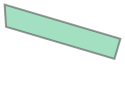

In [40]:
g

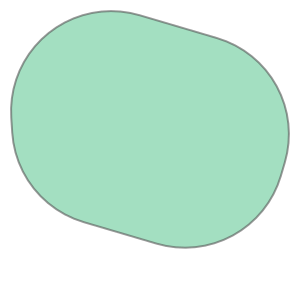

In [39]:
fil

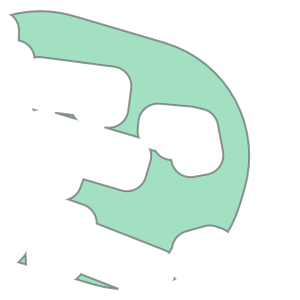

In [46]:
t = fil.difference(cascaded_union(polygon))
t

In [49]:
possible_matches

,height,base,geometry,area,BUILD_ID
12875,11.820,0.790,"POLYGON ((237017.6539405505 901353.5905856314,...",506.610,12875
12874,12.170,1.150,"POLYGON ((237199.5938805515 901363.4296656293,...",793.817,12874
12873,20.490,1.390,"POLYGON ((237142.3675505524 901348.946465629, ...",2620.960,12873
12872,7.210,-0.380,"POLYGON ((237044.3070005517 901416.8178456295,...",292.290,12872
37090,20.590,1.660,"POLYGON ((236974.2199005506 901412.72641563, 2...",1073.120,37090
37018,42.100,1.500,"POLYGON ((236972.6678905502 901455.6925156326,...",1069.295,37018
12869,11.750,-1.290,"POLYGON ((237027.0227605512 901476.8202856297,...",526.515,12869
12867,23.530,1.720,"POLYGON ((237109.7499205534 901488.5575756297,...",2466.090,12867
36944,8.410,1.670,"POLYGON ((236967.9101005506 901516.9634456306,...",76.053,36944
14082,10.410,-0.470,"POLYGON ((237191.1441805539 901506.458355629, ...",392.818,14082


In [96]:
x=[]
x, y = buildings.loc[37237].geometry.exterior.coords.xy
x[0]

236858.26083054894

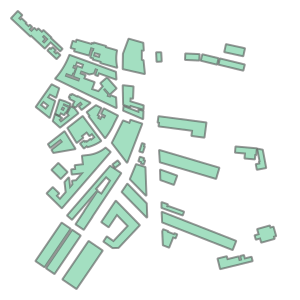

In [66]:
cascaded_union(polygon)

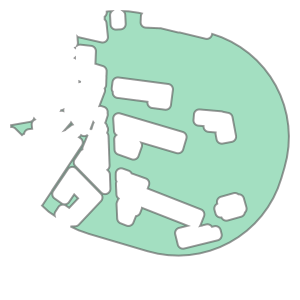

In [71]:
(fil.difference(cascaded_union(polygon))).difference(g)

In [70]:
%%time

# prominence

sindex = buildings.sindex

for row in buildings_clip.itertuples():
    
    g = row[3] #geometry
    fil = g.buffer(200)

    possible_matches_index = list(sindex.intersection(fil.bounds))
    possible_matches = buildings.iloc[possible_matches_index]
    #precise matches not necessary here
    
    if(len(possible_matches_index)<1): continue 
    
    polygon = MultiPolygon([pol.buffer(10) for pol in possible_matches['geometry']])
    print(row[0])
    area_max = (fil.difference(cascaded_union(polygon))).difference(g).area
    buildings_clip.set_value(row[0], 'prominence', area_max)
    break

12867
Wall time: 34.1 ms


## Neighbours

In [ ]:
%%time

# adjacent buildings
# a dataset containing a larger region of buildings than the one object of analyis is required here

spatial_index = buildings.sindex

for row in buildings_clip.itertuples():
    
    g = row[2] #geometry
    fil = g.buffer(150)    
    
    possible_matches_index = list(spatial_index.intersection(fil.bounds))
    possible_matches = buildings.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(fil)]
    
    buildings_clip.set_value(row[0], 'neighbours', len(precise_matches))

## Road distance

In [ ]:
road = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Street_network/boston_sn_26986_clipped_4000.shp')
                     .to_crs(epsg=26986))

net = road.geometry.unary_union

In [ ]:
%%time

# distance from road
for row in buildings_clip.itertuples():
    g = row[2] #geometry
    dist = g.distance(net)
    buildings_clip.set_value(row[0], 'distance_road', dist)

# Landuse

In [ ]:
# to be performed on the larger set of buildings
buildings['land_use'] = 'NaN'

## Parcels 

In [ ]:
# loading official Boston parcels

parcels = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/Parcels_2016/parcels.shp'
                        ).to_crs(epsg=26986))

In [ ]:
parcels = parcels[['geometry', 'LU']]
list(parcels['LU'].unique())

In [ ]:
residential = ['Residential Three Family', 'Residential Two Family', 'Residential Single Family',
               'Apartments 4-6 Units', 'Apartments 7 Units above', 'Residential Land', 'Residential Condo Unit',
                 'Condominium Master', 'Mixed Use Res/Comm']
               
commercial = ['Commercial Land','Commercial Condo Unit','Commercial']
agricultural = ['Agricultural/Horticultural']
              
industrial = ['Industrial']
drop = ['Condominium Parking', 'Exempt 121A', 'XX', 'Exempt']

In [ ]:
parcels = parcels[~parcels['LU'].isin(drop)]

In [ ]:
parcels['LU'] = parcels['LU'].map( lambda x: 'residential' if x in residential
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'industrial' if x in industrial
                                                          else 'agricultural'if x in agricultural 
                                                          else x)

In [ ]:
parcels['nr'] = 1

In [ ]:
%%time

sindex = parcels.sindex

for row in buildings.itertuples():
    
    g = row[2] #geometry
    possible_matches_index = list(sindex.intersection(g.bounds))
    possible_matches = parcels.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(g)]
        
    if (len(precise_matches)==0): continue
    
    else:
        
        land_use = precise_matches.groupby(['LU'],as_index=False)['nr'].sum().sort_values(by='nr',
                                    ascending=False).reset_index()
        main_use = land_use['LU'].loc[0]
        buildings.set_value(row[0], 'land_use', main_use)

## OpenStreetMap POI

In [ ]:
#land use from OSM POI

POI = gpd.read_file('Outputs/Boston/POI_boston.shp').to_crs(epsg=26986)
POI.head()

In [ ]:
list(POI['type'].unique())

In [ ]:
university = ['university', 'college', 'research']

commercial = ['bank', 'service',  'commercial',  'retail',  'pharmacy', 'commercial;educa', 'shop', 'Commercial',
                       'supermarket', 'offices', 'foundation', 'office']

residential = [ 'apartments']
attractions = ['museum',  'castle', 'cathedral', 'attraction','aquarium', 'monument',  'gatehouse']

manufacturing = []
hospitality = [ 'hotel',  'hostel', 'guest_house']
eating_drinking = [ 'restaurant', 'fast_food', 'cafe', 'bar',  'pub']
public = ['post_office', 'townhall', 'public_building',  'library','civic', 'courthouse','public',  'embassy']
library = ['library']
sport = ['stadium']
entertainment = [ 'exhibition_centr','theatre', 'cinema']
education = ['school', 'kindergarten']
religious = ['church', 'place_of_worship','convent', 'rectory']
 
emergency_service = [ 'fire_station','police']
transport = [ 'station', 'train_station']
medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary']
industrial = [ 'industrial', 'factory', 'construction']
cultural = [ 'club_house','gallery', 'arts_centre']
military = ['general aviation']

drop = ['subway_entrance', 'dormitory', 'roof', 'garage', 'storage_tank', 'shed', 'silo',  'parking',  'toilets','bus_station',
  'picnic_site','hut', 'information',  'viewpoint', 'atm', 'building', 'books',  'tower',  'terrace',  'canopy', 'smokestack',  
 'greenhouse', 'fuel']

In [ ]:
POI = POI[~POI['type'].isin(drop)]

In [ ]:
POI['type'] = POI['type'].map( lambda x: 'university' if x in university
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'attractions' if x in attractions
                                                          else 'library' if x in library
                                                          else 'manufacturing' if x in manufacturing
                                                          else 'hospitality' if x in hospitality
                                                          else 'eating_drinking' if x in eating_drinking
                                                          else 'public' if x in public
                                                          else 'sport' if x in sport
                                                          else 'entertainment' if x in entertainment
                                                          else 'education' if x in education
                                                          else 'religious' if x in religious
                                                          else 'emergency_service' if x in emergency_service
                                                          else 'industrial' if x in industrial
                                                          else 'cultural' if x in cultural
                                                          else 'transport' if x in transport
                                                          else 'medical_care' if x in medical_care
                                                          else 'military' if x in military
                                                          else x)

In [ ]:
POI['nr'] = 1

In [ ]:
%%time

sindex = POI.sindex

for row in buildings.itertuples():
    g = row[2] #geometry
    
    possible_matches_index = list(sindex.intersection(g.bounds))
    possible_matches = POI.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(g)]
    
    
    if (len(precise_matches)==0): continue
    else:
        land_use = possible_matches.groupby(['type'],as_index=False)['nr'].sum().sort_values(by='nr',
                                    ascending=False).reset_index()
        main_use = land_use['type'].loc[0]
        buildings.set_value(row[0], 'land_use', main_use)

## Other data from Boston

In [ ]:
# libraries and schools

schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/schools.shp'
                        ).to_crs(epsg=26986))

universities = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/universities.shp'
                        ).to_crs(epsg=26986))

p_schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/private_schools.shp'
                        ).to_crs(epsg=26986))

libraries = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/libraries.shp'
                        ).to_crs(epsg=26986))

pools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/pools.shp'
                        ).to_crs(epsg=26986))

police = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/police_stations.shp'
                        ).to_crs(epsg=26986))

In [ ]:
%%time

df_list = [schools, p_schools, libraries, universities, pools, police]
classification = ['education','education', 'library', 'university','sport', 'emergence_service']

for i, t in enumerate(df_list):
    sindex = t.sindex

    for row in buildings.itertuples():
        g = row[2] #geometry
    
        possible_matches_index = list(sindex.intersection(g.bounds))
        possible_matches = t.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(g)]
        
        if (len(precise_matches)==0): continue
        else:

            buildings.set_value(row[0], 'land_use', classification[i])

In [ ]:
buildings.land_use.fillna('residential', inplace=True)

In [ ]:
# buildings['land_use'].astype(object).fillna('residential', inplace=True)
buildings['land_use'].replace(to_replace='NaN', value='residential', inplace=True)
buildings.tail(10)

In [ ]:
buildings['land_use'].isnull().values.any()

In [ ]:
%%time

buildings['nr']=1
sindex = buildings.sindex
buildings['pragmatic_meaning']= 0.0

for row in buildings.itertuples():
    g = row[2] #geometry
    b = g.buffer(200)
    use = row[5]
    
    possible_matches_index = list(sindex.intersection(b.bounds))
    possible_matches = buildings.iloc[possible_matches_index]
#     precise_matches = buildings[buildings.intersects(g)]
        
    neigh = possible_matches.groupby(['land_use'], as_index=True)['nr'].sum()
    Nj = neigh.loc[use]
    #Pj = Nj/N
    
    Pj = 1-(Nj/possible_matches['nr'].sum())
    buildings.set_value(row[0], 'pragmatic_meaning', Pj)

In [ ]:
buildings.tail()

In [ ]:
buildings_clip = pd.merge(buildings_clip, buildings[['BUILD_ID','pragmatic_meaning']], on='BUILD_ID', how='left')

In [ ]:
buildings_clip.head()

# Cultural importance

In [357]:
#load historical polygons

historic = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/historic_landmarks.shp')).to_crs(epsg=26986)

In [ ]:
# historic = historic.dropna(subset=['geometry'])
# historic = historic.to_crs(epsg=26986)

In [358]:
%%time

sindex = historic.sindex 
buildings_clip['cultural_meaning'] = 0

for row in buildings_clip.itertuples():
    g = row[2] #geometry
    possible_matches_index = list(sindex.intersection(g.bounds))
    possible_matches = historic.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(g)]
        
    if (len(precise_matches)==0): continue
    
    else: 
        cm = len(precise_matches)

        buildings_clip.set_value(row[0], 'cultural_meaning', cm)

Wall time: 2.37 s


# Visibility 

In [359]:
visibility = pd.read_csv('Outputs/tmp/visibility.csv')

In [360]:
tmp = pd.merge(buildings_clip, visibility[['BUILD_ID','distance', 'mean_distance']], on='BUILD_ID', how='left')

In [361]:
tmp['distance'].fillna((tmp['distance'].min()), inplace=True)
tmp['mean_distance'].fillna((tmp['mean_distance'].min()), inplace=True)

In [362]:
tmp.rename(columns={'distance': 'visibility', 'mean_distance': 'mean_visibility'}, inplace=True)

In [363]:
tmp.head()

,height,geometry,area,BUILD_ID,width,length,extension,facade_area,prominence,neighbours,distance_road,pragmatic_meaning,cultural_meaning,visibility,mean_visibility
0,23.530,"POLYGON ((237109.7499205534 901488.5575756297,...",2466.090,12867,54.492,116.283,12589.692,1282.189,68296.187,23.000,7.116,0.273,0,2124.642,1141.259
1,11.750,"POLYGON ((237027.0227605512 901476.8202856297,...",526.515,12869,27.741,31.608,1831.787,325.961,44066.485,20.000,17.843,0.722,0,2108.577,892.880
2,7.210,"POLYGON ((237044.3070005517 901416.8178456295,...",292.290,12872,23.842,42.189,1338.164,171.900,51894.981,19.000,4.452,0.676,0,418.843,278.726
3,20.490,"POLYGON ((237142.3675505524 901348.946465629, ...",2620.960,12873,72.658,144.190,12204.878,1488.763,89283.033,18.000,4.109,0.444,1,2093.789,684.964
4,12.170,"POLYGON ((237199.5938805515 901363.4296656293,...",793.817,12874,31.392,39.969,3254.432,382.035,78097.239,7.000,27.316,0.500,0,2744.136,1427.360


In [364]:
tmp[['BUILD_ID','visibility']].sort_values('visibility', axis=0, ascending=False).head()

,BUILD_ID,visibility
1304,41166,6467.470
927,40717,5869.726
1519,41426,5713.939
1072,40883,5465.238
1352,41228,5260.460


In [365]:
col = ['area', 'extension', 'facade_area', 'height', 'pragmatic_meaning', 'prominence','cultural_meaning', 'visibility']

for i in col:
       tmp[i+"_scaled"] = (tmp[i]-tmp[i].min())/(tmp[i].max()-tmp[i].min())

In [366]:
col = ['neighbours', 'distance_road']

for i in col:
       tmp[i+"_scaled"] = 1-(tmp[i]-tmp[i].min())/(tmp[i].max()-tmp[i].min())

In [367]:
tmp_scaled = tmp[['BUILD_ID','geometry','area_scaled','extension_scaled','facade_area_scaled',
                 'height_scaled','prominence_scaled','cultural_meaning_scaled',
                 'neighbours_scaled','distance_road_scaled','pragmatic_meaning_scaled', 'visibility_scaled']].copy()

In [368]:
tmp_scaled['visual']=(tmp_scaled['facade_area_scaled']*30+tmp_scaled['height_scaled']*20
                      +tmp_scaled['visibility_scaled']*50)/100

In [369]:
tmp_scaled['structural']=(tmp_scaled['extension_scaled']*30+tmp_scaled['neighbours_scaled']*20+
                   tmp_scaled['prominence_scaled']*30+tmp_scaled['distance_road_scaled']*20)/100

In [370]:
col = ['visual', 'structural']

for i in col:
       tmp_scaled[i+"_scaled"] = (tmp_scaled[i]-tmp_scaled[i].min())/(tmp_scaled[i].max()-tmp_scaled[i].min())

In [371]:
weights = tmp_scaled[['BUILD_ID','geometry','visual_scaled','structural_scaled',
                      'cultural_meaning_scaled', 'pragmatic_meaning_scaled']].copy()

In [372]:
weights.crs

{'init': 'epsg:26986', 'no_defs': True}

In [373]:
weights['score']=(weights['visual_scaled']*50+weights['structural_scaled']*30+weights['cultural_meaning_scaled']*10+
                  weights['pragmatic_meaning_scaled']*10)/100

In [374]:
weights['score_scaled']=(weights['score']-weights['score'].min())/(weights['score'].max()-weights['score'].min())

In [375]:
weights.rename(columns={'visual_scaled': 'visual',
                        'structural_scaled':'structural',
                        'cultural_meaning_scaled': 'cultural',
                        'pragmatic_meaning_scaled':'pragmatic'}, inplace=True)

In [376]:
weights.head(10)

,BUILD_ID,geometry,visual,structural,cultural,pragmatic,score,score_scaled
0,12867,"POLYGON ((237109.7499205534 901488.5575756297,...",0.206,0.463,0.000,0.275,0.269,0.370
1,12869,"POLYGON ((237027.0227605512 901476.8202856297,...",0.180,0.347,0.000,0.729,0.267,0.367
2,12872,"POLYGON ((237044.3070005517 901416.8178456295,...",0.036,0.414,0.000,0.683,0.210,0.277
3,12873,"POLYGON ((237142.3675505524 901348.946465629, ...",0.204,0.559,0.200,0.449,0.334,0.474
4,12874,"POLYGON ((237199.5938805515 901363.4296656293,...",0.233,0.483,0.000,0.505,0.312,0.438
5,12875,"POLYGON ((237017.6539405505 901353.5905856314,...",0.177,0.450,0.200,0.489,0.292,0.407
6,12877,"POLYGON ((237119.0067105524 901311.3991456319,...",0.165,0.538,0.000,0.555,0.300,0.419
7,12880,"POLYGON ((237212.7256805532 901194.2015456287,...",0.240,0.471,0.000,0.617,0.323,0.456
8,12881,"POLYGON ((237133.2113405539 901161.9671356296,...",0.261,0.540,0.000,0.807,0.373,0.536
9,12883,"POLYGON ((237100.0512205517 901164.181105629, ...",0.168,0.441,0.000,0.959,0.312,0.438


In [377]:
weights.to_file(driver='ESRI Shapefile',filename="Outputs/Boston/boston_landmark_scores.shp")